In [1]:
import pickle, glob, matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os, sys, serial, time, visdom
from tqdm import tqdm, trange
from tabulate import tabulate
sys.path.append(r"C:\Users\gkoolstra\Documents\Code\qtrl")
sys.path.append(r"C:\Users\gkoolstra\Documents\Arduino\PID_control_sketch")
from pid import ArduinoPID
from qtrl.fitting import common, fit

%load_ext autoreload
%autoreload 2

<img src="Figures/PID_Schematic.png">

# Initialize the controller and turn off ramping 

In [2]:
Arnie = ArduinoPID()

Setting up a new session...


PID Initialized!


In [3]:
Arnie.dev.flush()

In [4]:
Arnie.set_ramping(False)

In [5]:
Arnie.test_sequence()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.97it/s]

╒════════════════════╤════════════════╕
│ Function call      │ Result         │
╞════════════════════╪════════════════╡
│ get_display_mode   │ V              │
├────────────────────┼────────────────┤
│ get_manual_status  │ 0              │
├────────────────────┼────────────────┤
│ get_ramping_status │ 0              │
├────────────────────┼────────────────┤
│ get_cts_dac_value  │ 0.0            │
├────────────────────┼────────────────┤
│ get_input          │ 0.008056640625 │
├────────────────────┼────────────────┤
│ get_output         │ 0.0            │
├────────────────────┼────────────────┤
│ get_setpoint       │ 0.0            │
├────────────────────┼────────────────┤
│ get_Kp             │ 2.0            │
├────────────────────┼────────────────┤
│ get_Ki             │ 5.0            │
├────────────────────┼────────────────┤
│ get_Kd             │ 0.0            │
╘════════════════════╧════════════════╛


# Monitor noise on the input

In [6]:
Arnie.set_ramping(False)

In [7]:
Arnie.set_manual_output(0.5, output=True)

In [8]:
Arnie.get_manual_status()

1

Input noise on the controller is 0.56mV


Text(0, 0.5, 'Input voltage (V)')

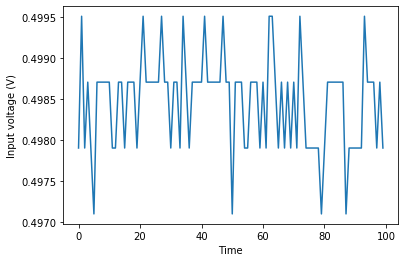

In [10]:
inp = Arnie.monitor_controller(100)
print(f"Input noise on the controller is {np.std(inp)*1e3:.2f}mV")

plt.figure()
plt.plot(inp)
plt.xlabel('Time')
plt.ylabel('Input voltage (V)')

# Test the PID controller to a step response

In [6]:
Arnie.set_ramping(False)
Arnie.set_manual_output(None, output=False)

In [7]:
Arnie.set_tuning_parameters(0.01, 2.5, 0.00)

In [8]:
Arnie.dev.flush()

In [13]:
Arnie.set_setpoint(1.0)

Input noise on the controller is 12.22mV


Text(0, 0.5, 'Input voltage (V)')

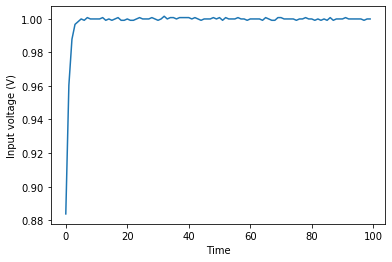

In [14]:
# target = 0.5
# Arnie.set_setpoint(target)
# time.sleep(0.25)
inp = Arnie.monitor_controller(100)
print(f"Input noise on the controller is {np.std(inp)*1e3:.2f}mV")

plt.figure()
plt.plot(inp)
plt.xlabel('Time')
plt.ylabel('Input voltage (V)')

# Test minimizer of the `cts_dac_output`

In [17]:
Arnie.get_Kd()

0.0

In [19]:
Arnie.test_sequence()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.99it/s]

╒════════════════════╤═══════════════════╕
│ Function call      │ Result            │
╞════════════════════╪═══════════════════╡
│ get_display_mode   │ V                 │
├────────────────────┼───────────────────┤
│ get_manual_status  │ 0                 │
├────────────────────┼───────────────────┤
│ get_ramping_status │ 0                 │
├────────────────────┼───────────────────┤
│ get_cts_dac_value  │ 0.0               │
├────────────────────┼───────────────────┤
│ get_input          │ 0.49951171875     │
├────────────────────┼───────────────────┤
│ get_output         │ 0.501018310546875 │
├────────────────────┼───────────────────┤
│ get_setpoint       │ 0.49951171875     │
├────────────────────┼───────────────────┤
│ get_Kp             │ 0.01              │
├────────────────────┼───────────────────┤
│ get_Ki             │ 2.5               │
├────────────────────┼───────────────────┤
│ get_Kd             │ 0.0               │
╘════════════════════╧═══════════════════╛


In [9]:
def minimize_cts_dac(cts_dac_sweep_pts, output):
    Arnie.set_manual_output(output, output=True)
    time.sleep(0.25)
    
    input_values = list()
    for cts_dac_pt in tqdm(cts_dac_sweep_pts):
        print(cts_dac_pt)
#         Arnie.set_manual_output(cts_dac_pt)
#         Arnie.set_cts_dac_output(cts_dac_pt)
        time.sleep(0.25)
        input_values.append(Arnie.get_input())
        time.sleep(0.25)
        
    y_data = np.array(input_values)
    x_data = cts_dac_sweep_pts
    
    g_offset = np.min(y_data)
    g_deriv = 1.0
    g_x0 = np.mean(x_data)
    
    fr = fit.fit1d(x_data, y_data, common.parabola, g_offset, g_deriv, g_x0, ret=True)
    
    if isinstance(fr, int):
        print("Fitting failed")
    else:
        cts_dac_setpoint = fr['params_dict']['x0']
        print(f"Setting 2nd DAC output to {cts_dac_setpoint:.3f} V")
#         Arnie.set_cts_dac_output(cts_dac_setpoint) # Set the cts dac value to the minimum
        Arnie.set_manual_output(None, output=False) # Turn on the controller again
        print(f"Optimized controller!")
        
    return x_data, y_data, fr

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

0.25


  9%|███████▌                                                                           | 1/11 [00:00<00:07,  1.31it/s]

0.275


 18%|███████████████                                                                    | 2/11 [00:01<00:06,  1.32it/s]

0.3


 27%|██████████████████████▋                                                            | 3/11 [00:02<00:06,  1.32it/s]

0.325


 36%|██████████████████████████████▏                                                    | 4/11 [00:03<00:05,  1.32it/s]

0.35


 45%|█████████████████████████████████████▋                                             | 5/11 [00:03<00:04,  1.32it/s]

0.375


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:04<00:03,  1.32it/s]

0.4


 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:05<00:03,  1.32it/s]

0.42500000000000004


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [00:06<00:02,  1.32it/s]

0.45


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [00:06<00:01,  1.32it/s]

0.475


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:07<00:00,  1.33it/s]

0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.32it/s]


Setting 2nd DAC output to 0.441 V
Optimized controller!


Text(0, 0.5, 'Controller input (V)')

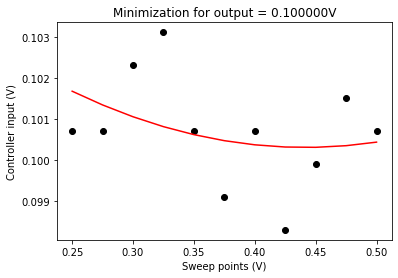

In [14]:
constant_pid_output = 0.10
second_dac_sweep_points = np.linspace(0.25, 0.50, 11)

x, y, fr = minimize_cts_dac(second_dac_sweep_points, constant_pid_output)

plt.figure()
plt.plot(x, y, 'ok')
plt.plot(x, fr['params_dict']['a'] + fr['params_dict']['k'] * (x - fr['params_dict']['x0'])**2, '-r')
plt.title(f"Minimization for output = {constant_pid_output:.3f}V")
plt.xlabel("Sweep points (V)")
plt.ylabel("Controller input (V)")